In [ ]:
! pip install pmdarima

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, RidgeClassifier, LogisticRegressionCV,Ridge,QuantileRegressor,PassiveAggressiveClassifier
from sklearn.ensemble import ExtraTreesRegressor,ExtraTreesClassifier,RandomForestClassifier,VotingClassifier,RandomForestRegressor,GradientBoostingClassifier,StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVC,LinearSVR,SVR
from sklearn.decomposition import TruncatedSVD,PCA,FactorAnalysis,KernelPCA,FastICA,NMF,LatentDirichletAllocation
from sklearn.preprocessing import RobustScaler,QuantileTransformer,PowerTransformer,PolynomialFeatures,KBinsDiscretizer,StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline,FeatureUnion,TransformerMixin
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor,LocalOutlierFactor
from sklearn.model_selection import train_test_split,ShuffleSplit,StratifiedShuffleSplit,TimeSeriesSplit,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.dummy import DummyRegressor,DummyClassifier
from sklearn import set_config
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,roc_auc_score,accuracy_score
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ADFTest
from pmdarima.arima.auto import auto_arima

In [3]:
train=pd.read_csv('/content/drive/MyDrive/Tula/train_dataset_train.csv',sep=';',
                  dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str, 'PATIENT_ID_COUNT':int})
test=pd.read_csv('/content/drive/MyDrive/Tula/test_dataset_test.csv',sep=';',
                 dtype={'PATIENT_SEX':str, 'MKB_CODE':str, 'ADRES':str, 'VISIT_MONTH_YEAR':str, 'AGE_CATEGORY':str, 'PATIENT_ID_COUNT':int})
train['date']=pd.to_datetime(train['VISIT_MONTH_YEAR'].str.replace('.20','.2020').str.replace('.18','.2018').str.replace('.19','.2019').str.replace('.21','.2021').str.replace('.22','.2022'),errors='coerce',format='%m.%Y')
train['day']=(train['date']-train['date'].min()).dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [ ]:
# Построение временных рядов для каждой четверки 'PATIENT_SEX'-'MKB_CODE'-'ADRES'-'AGE_CATEGORY'
bigind=pd.concat((train['PATIENT_SEX']+train['MKB_CODE']+train['ADRES']+train['AGE_CATEGORY'],
                  test['PATIENT_SEX']+test['MKB_CODE']+test['ADRES']+test['AGE_CATEGORY'])).value_counts().index
testind=test['PATIENT_SEX']+test['MKB_CODE']+test['ADRES']+test['AGE_CATEGORY']
XX=np.zeros((len(bigind),len(train['date'].value_counts())))
dlist=train['date'].value_counts().sort_index().index.tolist()
for cnt in range(51):
  train02=pd.Series([0]*len(bigind))
  train02c=train[train['date']==dlist[cnt]]
  train02.index=bigind
  train02c.index=train02c['PATIENT_SEX']+train02c['MKB_CODE']+train02c['ADRES']+train02c['AGE_CATEGORY']
  for cnt1 in train02.index:
    try:
      train02[cnt1]=train02c['PATIENT_ID_COUNT'][cnt1]
    except:
      pass
  XX[:,cnt]=train02.values

In [8]:
# Оценка оптимального параметра логарифмического сглаживания
np.exp(-np.log(XX[XX>1]).sum()/(XX<1).sum())

0.9333636050385958

In [9]:
# PCA
pcal=PCA(50,random_state=0)
XX2pl=pcal.fit_transform(np.log(XX.T+0.9333636050385958))

Text(0.5, 1.0, 'Динамика главных компонент +1')

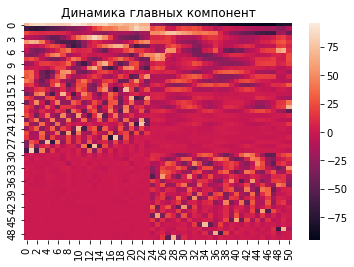

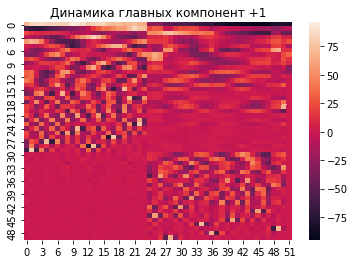

In [56]:
# Главные компоненты, визуализация
sns.heatmap(XX2pl.T)
plt.title('Динамика главных компонент')
plt.figure()
sns.heatmap(np.hstack((XX2pl.T,XX3l)))
plt.title('Динамика главных компонент +1')

In [87]:
# ARIMA для пятидесяти главных компонент
XX3l=np.zeros((XX2pl.T.shape[0],1))
for cnt in range(50):
  model=auto_arima(pd.Series(XX2pl.T[cnt]).diff().dropna().values, X=None, start_p=0, d=0, start_q=0, 
                   max_p=12, max_d=4, max_q=12, 
                   start_P=1, D=0, start_Q=1, 
                   max_P=2, max_D=1, max_Q=2, max_order=5, m=1, 
                   seasonal=True, stationary=False, information_criterion='aic', 
                   alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, 
                   n_jobs=1, start_params=None, trend=None, method='lbfgs', 
                   maxiter=50, offset_test_args=None, seasonal_test_args=None, 
                   suppress_warnings=True, error_action='trace', trace=False, 
                   random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse')
  XX3l[cnt,0]=model.predict()[0]+XX2pl.T[cnt][-1]

In [88]:
# Обратное PCA
XX4l=np.exp(pcal.inverse_transform(XX3l.T)[0])-0.9333636050385958

In [90]:
# Нормирование на 1
XX4l[XX4l<=1]=1

In [91]:
# Запись прогноза в файл
XX4l=pd.Series(XX4l)
XX4l.index=bigind
testindex=testind
test['PATIENT_ID_COUNT']=XX4l
answer=test[['PATIENT_SEX', 'MKB_CODE', 'ADRES', 'VISIT_MONTH_YEAR', 'AGE_CATEGORY',
       'PATIENT_ID_COUNT']]
answer.to_csv('sample_solution.csv',sep=';',index=False)
answer       